In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests_hw4 import test_prediction, test_generation

In [2]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle


    def __iter__(self):
        # concatenate your articles and build into batches
        # 1. Shuffle data
        if self.shuffle:
            np.random.shuffle(self.dataset)
        # 2. Concatenate articles and drop extra words
        new_dataset = np.concatenate(self.dataset)
        num_batches = (len(new_dataset)-1) // self.batch_size
        
        window = num_batches*self.batch_size
        # inputs
        inputs = new_dataset[:window].reshape(self.batch_size, -1)
        inputs = torch.LongTensor(inputs)
        # targets
        targets = new_dataset[1:window+1].reshape(self.batch_size, -1)
        targets = torch.LongTensor(targets)
        
        batch_idx = 0
        while batch_idx < num_batches:
        # ======================================================
        #                   adapted from paper
        # Title: Regularizing and Optimizing LSTM Language Models
        # Authors: 
        # - Stephen Merity
        # - Nitish Shirish Keskar
        # - Richard Socher
        # Section 4.1: Variable length backpropagation sequences
        # =======================================================
            p = np.random.random_sample()
            if p < 0.95:
                self.seq_len = round(np.random.normal(25, 5))
            else:
                self.seq_len = round(np.random.normal(19, 5))
            
            # 3. batching
            inp = inputs[:, batch_idx:batch_idx+self.seq_len].T
            tgt = targets[:, batch_idx:batch_idx+self.seq_len].T
            
            # update batch index
            batch_idx += self.seq_len
            
            # 4. return
            yield inp, tgt # -->(seq_len, batch_size)

In [5]:
dl = LanguageModelDataLoader(dataset=dataset, batch_size=128)

In [6]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embedding_dim:int=512, hidden_size:int=512, num_layers:int=3, bidir:bool=False):
        super(LanguageModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.encoder = nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, 
            bidirectional=bidir, 
            batch_first=False
        )
        if bidir:
            n = 2
        else:
            n = 1
        self.decoder = nn.Linear(in_features=self.hidden_size* n, out_features=self.vocab_size)
        self.decoder.weight = self.embedding.weight # weight tying

    def forward(self, x, hidden=None):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        S, BS = x.size()
        
        out = self.embedding(x)
        out = self.dropout(out)
        out, hidden = self.encoder(out, hidden)
        out = out.reshape(-1, self.hidden_size)
        out = self.decoder(out)
        # format output: ---> (seq_len, batch_size, vocab_size)
        out = out.view(-1, BS, self.vocab_size)
        
        return out

In [7]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, lr=3e-3, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        self.lr = lr
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), weight_decay=1e-6, lr=self.lr) # adam is better with quite little lr
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=1, gamma=.6)

    def train(self):
        self.model.train() # set to training mode
        self.model.to(device)
        epoch_loss = 0
        num_batches = 0
        
        for batch_num, (inputs, targets) in enumerate(self.loader):
            loss = self.train_batch(inputs, targets)
            epoch_loss += loss
        
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)
        self.scheduler.step()

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        inputs, targets = inputs.to(device), targets.to(device)
        
        out = self.model(inputs)
        # format inputs to the loss function
        out = out.view(-1, out.size(2))
        targets = targets.contiguous().view(-1) # flatten targets
        loss = self.criterion(out, targets)
        
        # backward pas
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [8]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        model.eval()
        with torch.no_grad():
            inp = inp.T
            inp = torch.tensor(inp).long().to(device)
            out = model(inp)
            pred = out[-1, :]
        
        return pred.detach().cpu().numpy()

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """        
        model.eval()
        with torch.no_grad():
            inp = torch.tensor(inp).long().to(device)
            for _ in range(forward):
                fwd_input = inp.permute(1, 0)
                # prediction
                out = model(fwd_input)[-1, :]
                word = torch.argmax(out, dim=1, keepdim=True)
                inp = torch.cat((inp, word), dim=1) # add pred to all predicions
            words = inp[:, -forward:] # keep last perdicted words
        return words.detach().cpu().numpy()
        

In [9]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 8
BATCH_SIZE = 128
LR = 4e-3
EMB_DIM = 350
HIDDEN_SIZE = 350

In [10]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1660140134


In [11]:
model = LanguageModel(len(vocab), embedding_dim=EMB_DIM, hidden_size=HIDDEN_SIZE)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id, lr=LR)

In [12]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()
    

[TRAIN]  Epoch [2/8]   Loss: 6.2864
[VAL]  Epoch [1/8]   Loss: 4.9540
Saving model, predictions and generated output for epoch 0 with NLL: 4.953958
[TRAIN]  Epoch [3/8]   Loss: 5.4123
[VAL]  Epoch [2/8]   Loss: 4.5906
Saving model, predictions and generated output for epoch 1 with NLL: 4.590621
[TRAIN]  Epoch [4/8]   Loss: 5.0944
[VAL]  Epoch [3/8]   Loss: 4.4269
Saving model, predictions and generated output for epoch 2 with NLL: 4.4269104
[TRAIN]  Epoch [5/8]   Loss: 4.8970
[VAL]  Epoch [4/8]   Loss: 4.4632
[TRAIN]  Epoch [6/8]   Loss: 4.7561
[VAL]  Epoch [5/8]   Loss: 4.4534
[TRAIN]  Epoch [7/8]   Loss: 4.6664
[VAL]  Epoch [6/8]   Loss: 4.4704
[TRAIN]  Epoch [8/8]   Loss: 4.6002
[VAL]  Epoch [7/8]   Loss: 4.4910
[TRAIN]  Epoch [9/8]   Loss: 4.5668
[VAL]  Epoch [8/8]   Loss: 4.5118


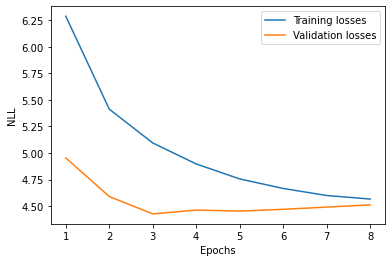

In [13]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [14]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | also used to attack the <unk> , which had been
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> On July 7 , 2009 ,
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single , " Best <unk> " , and " <unk>
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and the <unk> of the <unk> , the <unk> ,
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | <unk> . The first time the ship had been damaged
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | <unk> <unk> ( <unk> ) , <unk> ( <unk> )
Input | Output #6: <unk> , $ 96 million USD ) . Dama